# 1. Normal

In [29]:
from typing import Annotated, Optional
from uuid import uuid4

from langchain.chat_models import init_chat_model
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langchain_core.messages import trim_messages
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

class ChatState(TypedDict):
    messages: Annotated[list, add_messages]
    rewritten_messages: Annotated[list, add_messages]
    topic_decision: str

In [30]:
llm_rewriter = init_chat_model("openai:gpt-4o-mini", temperature=0.0)
llm_classifier = init_chat_model("openai:gpt-4o-mini", temperature=0.0)
llm_main = init_chat_model("openai:gpt-4o", temperature=0.7, streaming=True)
llm_fallback = init_chat_model("openai:gpt-4o-mini", temperature=0.7, streaming=True)

In [31]:
def get_context_for_classification(messages, max_chars=1000):
    """
    Trim rápido usando caracteres como proxy de tokens
    Estimación: ~4 caracteres por token en español
    """
    if len(messages) <= 5:
        return messages
    
    # Función inline para contar caracteres
    def count_chars(msgs):
        return sum(len(msg.content) for msg in msgs)
    
    trimmer = trim_messages(
        max_tokens=max_chars,
        strategy="last", 
        token_counter=count_chars,
        include_system=False,
        allow_partial=False,
        start_on="human",
    )
    
    return trimmer.invoke(messages)

In [32]:
rewriter_msg = SystemMessage(
    content=(
        "Eres un asistente especializado en reescribir preguntas para alinearlas con el contexto de transparencia gubernamental del Estado peruano. "
        "Tu objetivo es transformar las preguntas del usuario en consultas más claras, formales y orientadas a la fiscalización y el acceso a información pública."

        "Reescribe las preguntas del usuario únicamente si están relacionadas con alguno de los siguientes temas:"
        "- Contrataciones públicas (montos, órdenes de servicio, contratos, proveedores)"
        "- Empresas que han contratado con el Estado peruano"
        "- Asistencia y votaciones de congresistas"
        "- Información relacionada a congresistas (identidad, región, actividad legislativa)"

        "Si la pregunta **no** está relacionada con estos temas, **devuélvela sin cambios**."
        "Tu respuesta debe ser únicamente la **pregunta reformulada**, sin explicaciones ni comentarios adicionales."
        
        "Ejemplos:"
        "Entrada: quien es alejando muñante"
        "Salida: Busca en la web información sobre el congresista ALEJANDRO MUÑANTE."

        "Entrada: quien es Sucel Paredes"
        "Salida: Busca en la web información sobre la congresista SUCEL PAREDES."

        "Entrada: quienes son los congresistas de la region de huancayo"
        "Salida: Busca en la web información sobre los congresistas de la región de HUANCAYO."
        
        "Entrada: dame las asistencias del 2022 octubre"
        "Salida: ¿Cuáles fueron las asistencias de los congresistas en octubre de 2022?"

        "Entrada: puedes darme las asistencias del 10 de diciembre del 2022"
        "Salida: ¿Cuáles fueron las asistencias de los congresistas el 2022-12-10?"

        "Entrada: puedes decirme las votaciones del congreso del 10 de diciembre del 2022"
        "Salida: ¿Cuáles fueron las votaciones de los congresistas el 2022-12-10?"

        "Entrada: que asuntos se trataron en el congreso del 10 de diciembre del 2022"
        "Salida: ¿Cuáles fueron los asuntos tratados en las votaciones del 2022-12-10?"

        "Entrada: cuánto ha contratado constructora alfa"
        "Salida: ¿Cuánto ha contratado la empresa 'CONSTRUCTORA ALFA' con el Estado peruano según transparencia pública?"

        "Entrada: detalles de los contratos de constructora alfa"
        "Salida: ¿Cuáles son los detalles de los contratos de la empresa 'CONSTRUCTORA ALFA'?"

        "Entrada: detalles de las ordenes de servicio de constructora alfa"
        "Salida: ¿Cuáles son los detalles de las órdenes de servicio de la empresa 'CONSTRUCTORA ALFA'?"

        "Entrada: Que más me puedes decir?"
        "Salida: Que más me puedes decir?"

        "Entrada: Me gustan los duraznos"
        "Salida: Me gustan los duraznos"

        "Entrada: Quien ganó la champions league"
        "Salida: Quien ganó la champions league"
    )
)

In [33]:
def rewrite_node(state: ChatState) -> ChatState:
    """Reescribe la última pregunta del usuario con llm_rewriter."""
    
    last_user_msg: HumanMessage = state["messages"][-1]   # asumimos último mensaje = usuario
    rewritten = llm_rewriter.invoke([rewriter_msg, last_user_msg])

    # Añadimos la versión reescrita como HumanMessage (para mantener formato)
    return {
        "messages": state["messages"] + [HumanMessage(content=last_user_msg.content)],
        "rewritten_messages": state["rewritten_messages"] + [HumanMessage(content=rewritten.content)],
        "topic_decision": state.get("topic_decision", "")
    }

In [34]:
graph = StateGraph(ChatState)

graph.add_node("rewriter", rewrite_node)

graph.add_edge(START, "rewriter")
graph.add_edge("rewriter", END)

enhanced_processor = graph.compile(checkpointer=memory)

In [38]:
# Ejemplo de uso
session_id = "abc123"

# Test 1: Pregunta sobre transparencia gubernamental (debe ir a main)
print("=== Test 1: Pregunta sobre contrataciones ===")
state = enhanced_processor.invoke(
    {
        "messages": [HumanMessage(content="Que empresas tienen contratos por más de 1000000 de soles")],
        "topic_decision": ""
    },
    config={"thread_id": session_id}
)
print(f"Pregunta original: {state['messages'][-1].content}")
print(f"Pregunta reescrita: {state['rewritten_messages'][-1].content}")
print()

# Test 2: Pregunta general (debe ir a fallback)
print("=== Test 2: Pregunta general ===")
state = enhanced_processor.invoke(
    {
        "messages": [HumanMessage(content="Quien ganó la Champions League")],
        "topic_decision": ""
    },
    config={"thread_id": session_id}  
)
print(f"Pregunta original: {state['messages'][-1].content}")
print(f"Pregunta reescrita: {state['rewritten_messages'][-1].content}")
print()

# Test 3: Pregunta sobre asistencias (debe ir a main)
print("=== Test 3: Pregunta sobre asistencias ===")
state = enhanced_processor.invoke(
    {
        "messages": [HumanMessage(content="dame las asistencias del 2022 octubre")],
        "topic_decision": ""
    },
    config={"thread_id": session_id}  
)
print(f"Pregunta original: {state['messages'][-1].content}")
print(f"Pregunta reescrita: {state['rewritten_messages'][-1].content}")
print()

# Test 4: Pregunta sobre que mas puedes hacer
print("=== Test 4:  sobre que mas puedes hacer ===")
state = enhanced_processor.invoke(
    {
        "messages": [HumanMessage(content="que mas puedes hacer")],
        "topic_decision": ""
    },
    config={"thread_id": session_id}  
)
print(f"Pregunta original: {state['messages'][-1].content}")
print(f"Pregunta reescrita: {state['rewritten_messages'][-1].content}")
print()

# Test 5: Pregunta sobre los contratos de la empresa constructora alfa
print("=== Test 5: Pregunta sobre los contratos de la empresa constructora alfa ===")
state = enhanced_processor.invoke(
    {
        "messages": [HumanMessage(content="detalles de los contratos de constructora alfa")],
        "topic_decision": ""
    },
    config={"thread_id": session_id}  
)
print(f"Pregunta original: {state['messages'][-1].content}")
print(f"Pregunta reescrita: {state['rewritten_messages'][-1].content}")
print()

=== Test 1: Pregunta sobre contrataciones ===
Pregunta original: Que empresas tienen contratos por más de 1000000 de soles
Pregunta reescrita: ¿Cuáles son las empresas que tienen contratos con el Estado peruano por un monto superior a 1,000,000 de soles?

=== Test 2: Pregunta general ===
Pregunta original: Quien ganó la Champions League
Pregunta reescrita: Quien ganó la Champions League

=== Test 3: Pregunta sobre asistencias ===
Pregunta original: dame las asistencias del 2022 octubre
Pregunta reescrita: ¿Cuáles fueron las asistencias de los congresistas en octubre de 2022?

=== Test 4:  sobre que mas puedes hacer ===
Pregunta original: que mas puedes hacer
Pregunta reescrita: Que más puedes hacer?

=== Test 5: Pregunta sobre los contratos de la empresa constructora alfa ===
Pregunta original: detalles de los contratos de constructora alfa
Pregunta reescrita: ¿Cuáles son los detalles de los contratos de la empresa 'CONSTRUCTORA ALFA'?



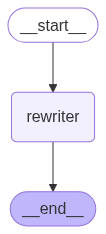

In [36]:
from IPython.display import Image, display

display(Image(enhanced_processor.get_graph().draw_mermaid_png()))